## Geneious analysis for individual samples from  Geneious output, "Annotation.csv" ##

## Required packages
 - Pandas
 - Numpy
 - Seaborn
 - matplotlib
 
## Inputs 
    - Geneious SNP analysis of six drug resistance markers (Pfk13, Pfcrt, Pfmdr1, Pfdhfr, Pfdhps, and Pfcytb) in csv file
    - Variants of interest file 
    
####  * More details on how to run the Jupyter code can be found in Readme file.




### The below code section will output the csv file **"*_individual_EPI_VOI.csv"** which reports all the SNPs of interest, as defined by the VariantsOfInterest.csv file, that were called by the Geneious workflow for individually sequenced samples.

In [4]:
import pandas as pd           ## Import Pandas library for processing dataframe as pd
import numpy as np            ## Import Numy for processing matrix as np
import sys                    ## Import sys library for maximizing the csv limit for large csv file which can be Geneious file.
import csv                    ## Import csv module to input the csv file to dataframe 

csv.field_size_limit(sys.maxsize)                                                                                                         ##Maximize the csv file input size
Geneious_raw_DF=pd.read_csv("Annotations.csv", engine='python', error_bad_lines=False)                                                    ##Import raw Geneious output table for variant analysis genes. Set up engine equals python and error_bad_lines for preventing errors with processing large csv files
Geneious_DF_filtered_poly=Geneious_raw_DF[(Geneious_raw_DF['Type']=='Polymorphism') & (Geneious_raw_DF['Amino Acid Change'].notnull())]   ##If the type column contains polymorphism and Amino Acid Change column is not empty then create a dataframe satisfying those conditions
Geneious_DF_filtered_cov=Geneious_raw_DF[Geneious_raw_DF['Type']=='Coverage - High']                                                      ##If the Coverage - High is in the type column as value then select dataframe for those column values
Geneious_DF_filtered_poly["TrackerSNP"]=(Geneious_DF_filtered_poly["Amino Acid Change"].astype(str).str[0]+                               ##Create a TrackerSNP Column which has both amino acid before the change
Geneious_DF_filtered_poly["CDS Codon Number"].astype(int).astype(str)+                                                                    ##Create a TrackerSNP Column which has CDC Codon number for amino acid change location
Geneious_DF_filtered_poly["Amino Acid Change"].astype(str).str[-1])                                                                       ##Create a TrackerSNP Column which has both amino acid after the change
Pre_Combined_Variant_Wildtype = [Geneious_DF_filtered_poly, Geneious_DF_filtered_cov]                                                     ##Produce a complete dataframe which contains both variants and wildtypes
Combined_Vi_Wi = pd.concat(Pre_Combined_Variant_Wildtype)                                                                                 ##Concatenate the dataframes for variants and wildtypes
Combination_filtered_dup=Combined_Vi_Wi.drop_duplicates(subset =["Document Name", "TrackerSNP"] )                                         ##Drop duplicates meaning if the values are already in variants then drop it from the wildtypes
                                                                                                                                          ##The dataframe contains information, "Sample,POOLED,Year,SITE,TreatmentDay,GENE,G_ANNOTATION,COVERAGE,VAF,VF,SNP,TYPE\n")

def site(row):                                ##Set up a function for assignging site based on the values in the document name column. This will change with each study please update the sites. 
    if row['Document Name'][4:6]=="Vo":       ##Assign Amhara for the abbreviation
        return 'VOHnj'
    if row['Document Name'][4:6]=="Ma":       ##Assign Amhara for the abbreviation
        return 'MAdagascar'


def POOLEDsize(row):                                          ##Set up a function for assigning TreatmentDay based on the values in the document name column
    if row['Document Name'].replace(" ","")[13:14]=="0":      ##If 0 in the position 13 of the string
        return row['Document Name'].replace(" ","")[14:15]    ##then assign only position 14 as POOLED size
    elif row['Document Name'].replace(" ","")[13:14]!="0":    ##If 0 not in the position 13 of the string
        return row['Document Name'].replace(" ","")[13:15]    ##then assign the string from 13 and 14

def TreatmentDay(row): ##Set up a function for assigning TreatmentDay based on the values in the document name column
    if row['Document Name'][6:8]=="00":
        return '0'
    elif row['Document Name'][6:8]=="1A": 
        return '1'
    elif row['Document Name'][6:8]!="00" and row['Document Name'][6:8]!="1A":
        return row['Document Name'][6:8]   

def POOLED(row):                                              ##Set up a function for POOLED based on the values in the document name column
    if row['Document Name'].replace(" ","")[12:13]=="p":      ##If position 12 has p in it
        return 'POOLED'                                       ##then it is considered POOLED sample
    elif row['Document Name'].replace(" ","")[12:13]!="p":    ##If position 12 has no p in it
        return 'individual'                                   ##then it is considered individual sample

def year(row):  ##Set up a function for Year  based on the values in the document name column
    return row['Document Name'][0:2]

def type_SNP(row):  ##Set up a TYPE column based on given value in the Type whether it is mutation or wildtype
    if row['Type'] =='Polymorphism':  ##Type is either mutation or wildtype
        return "mutation"
    if row['Type'] =='Coverage - High':
        return "wildtype"
    
def SNP(row):  ##Set up a SNP column to give pre or post amino acid changes based on mutation or wildtype
    if row['Type'] =='Polymorphism':  ##Set up SNP notation for wildtype or mutation
        return row['TrackerSNP'][1::]
    if row['Type'] =='Coverage - High':
        return row['TrackerSNP'][0:-1]
    
def name(row):
    return row['Document Name'].split("_")[0].replace(" ","") ##Split the document name with _ and assign first substring to clean up the name of the sample
  
##Apply the functions defined previously for assigning site,TreatmentDay,POOLED,year,type,SNP,name
Combination_filtered_dup[["SITE",'TREATMENT_DAY', "POOLED","YEAR","TYPE","SNP","Document Name" ,"POOLEDSIZE"]] = Combination_filtered_dup.apply([site,TreatmentDay,POOLED,year,type_SNP,SNP,name,POOLEDsize], axis=1)

Combination_report1=Combination_filtered_dup[Combination_filtered_dup['Type']=='Polymorphism'] ##Select columns with mutations
Combination_report2=Combination_filtered_dup[Combination_filtered_dup['Type']=='Coverage - High'] ##Select columns with wildtypes
final_report1=Combination_report1[["Document Name","Sequence Name","SITE",'TREATMENT_DAY',"POOLED","YEAR","Coverage","Variant Frequency","Variant Raw Frequency","TrackerSNP","TYPE","SNP","POOLEDSIZE"]] ##Assign sample information to samples with mutation
final_report2=Combination_report2[["Document Name","Sequence Name","SITE",'TREATMENT_DAY',"POOLED","YEAR","Average Coverage","Variant Frequency","Variant Raw Frequency","TrackerSNP","TYPE","SNP","POOLEDSIZE"]] ##Assign sample information to samples with wildtypes
final_report2_re=final_report2.rename(columns={'Average Coverage': 'Coverage'}) ##Change the name of average coverage to coverage for samples with wildtypes
final_combine=[final_report1, final_report2_re] ##Combine the information from wildtypes and mutations into one dataframe
final_combine_2=pd.concat(final_combine) ##concatenate

###This part is for polishing lab version of individual
final_combine_4=final_combine_2[final_combine_2["POOLED"]=="individual"] 

##create another dataframe where POOLED column is just individual
#replace the rename part with one line code using dictonary
final_combine_4=final_combine_4.rename(columns={'Document Name': 'ET_ID_IND','Sequence Name': 'GENE','TrackerSNP': 'G_ANNOTATION', 'Coverage': 'COVERAGE','Variant Frequency': 'VAF','Variant Raw Frequency': 'VF' })


cols = list(final_combine_4.columns) ##Change columns into list
a, b = cols.index('SNP'), cols.index('TYPE') ##Index the column to swtich the order to match the previous Guinea report
cols[b], cols[a] = cols[a], cols[b] ##Change order of the column
final_combine_4 = final_combine_4[cols] ##After reordering the columns reassign to the dataframe
#fill the empty value on multiple columns using dict
values = {"VAF": "0%", "VF": "0"}
final_combine_4 = final_combine_4.fillna(value=values)

final_combine_4=final_combine_4.replace({'Pf': 1})
final_combine_4=final_combine_4.replace({'xx': 1})
final_combine_4=final_combine_4.drop('POOLEDSIZE', 1)
#final_combine_4=final_combine_4.replace({'DHPS ': 'DHPS'})

#final_combine_4=final_combine_4[final_combine_4['SITE'].notnull()] ##Check if the site is empty or not and assign site 
#final_combine_4.to_csv("ET_individual_EPI.csv", sep=',', index=False) ##Create a file with the dataframe for testing purpose this is internal lab version

df_voi=pd.read_csv("VariantsOfInterest.csv")
df_voi["VOI"]=df_voi["RefAA"]+df_voi["AAPos"].astype(str)+df_voi["AltAA"]
voi_list=df_voi["VOI"].tolist()

final_combine_4_voi=final_combine_4[final_combine_4.G_ANNOTATION.isin(voi_list)]
#print(final_combine_4_voi)
final_combine_4_voi.to_csv("MD_individual_EPI_VOI.csv", sep=',', index=False)

/var/folders/63/dlkj48z90j97v_lywzxm0kh00000gr/T/ipykernel_47962/1050412970.py:7: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  Geneious_raw_DF=pd.read_csv("Annotations.csv", engine='python', error_bad_lines=False)                                                    ##Import raw Geneious output table for variant analysis genes. Set up engine equals python and error_bad_lines for preventing errors with processing large csv files
/var/folders/63/dlkj48z90j97v_lywzxm0kh00000gr/T/ipykernel_47962/1050412970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Geneious_DF_filtered_poly["TrackerSNP"]=(Geneious_DF_filtered_poly["Amino Acid Change"].astype(str).s

### The below code section will output the csv file **"*_POOLED_EPI_VOI.csv"** which reports all the SNPs of interest, as defined by the VariantsOfInterest.csv file, that were called by the Geneious workflow for Pooled samples.

In [5]:
#POOLED_part1=pd.read_csv("POOLED_Info.csv") ##import a file with information about POOLED samples

#final_combine_2.rename(columns={'Document Name':'AMD ID (POOLED)'}, inplace=True) ##Reanme the document name to AET_ID


df_merged_poolsize = final_combine_2#[final_combine_2["POOLED"]=="POOLED"] ##merge the information based on AET_ID to add POOLED columns and POOLED size columns

#df_merged_poolsize = df_merged_poolsize.drop(['SITE ','Year_y'], axis=1) ##Get rid of duplicate columns which is SITE and year_y

#df_merged_poolsize.PoolSize.fillna(value=1, inplace=True) ##Fill empty values for poolsize for individual with 1s

df_merged_poolsize['Variant Frequency'] = df_merged_poolsize['Variant Frequency'].fillna("0%") ##Fill the empty Variant Frequency value with 0
df_merged_poolsize['Variant Raw Frequency'] = df_merged_poolsize['Variant Raw Frequency'].fillna(0) ##Fill empty values with 0s
#print(df_merged_poolsize)
#df_merged_poolsize["Prod"]=df_merged_poolsize["Variant Frequency"].str.split('%').str[0].str.strip("%").astype(float)*df_merged_poolsize["POOLEDsize"].astype(float) ##Get a product by multiplying variant frequency times the pool size
df_merged_poolsize.rename(columns={'Variant Frequency':'VAF', 'Variant Raw Frequency':'VF'}, inplace=True) ##Reanme the document name to AET_ID
df_merged_poolsize['Coverage'] = df_merged_poolsize['Coverage'].apply(str) ##Change values from numeric to string
df_merged_poolsize['VAF'] = df_merged_poolsize['VAF'].apply(str) ##Change values from numeric to string
df_merged_poolsize['VF'] = df_merged_poolsize['VF'].apply(str)  ##Change values from numeric to string
df_merged_poolsize.Coverage= df_merged_poolsize.Coverage.str.split(" ").str[0]  ##Split the string by space for values with -> then pick the substring before the first space
df_merged_poolsize.VAF= df_merged_poolsize.VAF.str.split(" ").str[0] ##Split the string by space for values with -> then pick the substring before the first space
df_merged_poolsize.VF= df_merged_poolsize.VF.str.split(" ").str[0] ##Split the string by space for values with -> then pick the substring before the first space
df_merged_poolsize.rename(columns={'VAF': 'Variant Frequency', 'VF':'Variant Raw Frequency'}, inplace=True) ##Reanme the document name to AET_ID
df_merged_poolsize=df_merged_poolsize.rename(columns={'Document Name': 'ET_ID_POOLED','Sequence Name': 'GENE','TrackerSNP': 'G_ANNOTATION', 'Coverage': 'COVERAGE','Variant Frequency': 'VAF','Variant Raw Frequency': 'VF'  })


#df_merged_poolsize=df_merged_poolsize.replace({'DHPS_437Corrected ': 'DHPS'})  ##Rename DHPS_437Corrected values to DHPS to correct the name
df_merged_poolsize=df_merged_poolsize.replace({'DHPS ': 'DHPS'}) 
df_merged_poolsize=df_merged_poolsize.replace({'Pf': 1})

df_merged_poolsize2=df_merged_poolsize[df_merged_poolsize["POOLED"]=="POOLED"]
#df_merged_poolsize2 = df_merged_poolsize2.drop('Prod',  1)

#df_merged_poolsize2.to_csv("ET_POOLED_EPI.csv", index=False)

df_merged_poolsize_ind_pool=df_merged_poolsize
#df_merged_poolsize2 = df_merged_poolsize2.drop('Prod',  1)

df_voi=pd.read_csv("VariantsOfInterest.csv")
df_voi["VOI"]=df_voi["RefAA"]+df_voi["AAPos"].astype(str)+df_voi["AltAA"]
voi_list=df_voi["VOI"].tolist()

df_merged_poolsize2_voi=df_merged_poolsize2[df_merged_poolsize2.G_ANNOTATION.isin(voi_list)]

df_merged_poolsize2_voi=df_merged_poolsize2_voi.replace({'Pf': 1})

df_merged_poolsize2_voi.to_csv("ET_POOLED_EPI_VOI.csv", index=False)

#df_merged_poolsize_ind_pool.to_csv("ET_POOLED_EPI_QC.csv", index=False)

df_merged_poolsize_ind_pool_voi=df_merged_poolsize_ind_pool[df_merged_poolsize_ind_pool.G_ANNOTATION.isin(voi_list)]

#df_merged_poolsize_ind_pool_voi.to_csv("ET_POOLED_EPI_QC_voi.csv", index=False)

df_merged_poolsize=df_merged_poolsize.replace({'xx': 1})

df_merged_poolsize=df_merged_poolsize.replace({'Pf': 1})

df_merged_poolsize["POOLEDSIZE"] = pd.to_numeric(df_merged_poolsize["POOLEDSIZE"])

df_merged_poolsize["Prod"]=df_merged_poolsize["VAF"].str.split('%').str[0].str.strip("%").astype(float)*df_merged_poolsize["POOLEDSIZE"].astype(float) ##Get a product by multiplying variant frequency times the pool size




### The below code Reports a weighted variants allele frequency(VAF) average per gene for each SNPs by site/province. 

In [6]:
#print(df_merged_poolsize)
df_merged_count=df_merged_poolsize.groupby(['SITE','GENE','G_ANNOTATION', 'POOLED']).sum()  ##Sum the columns based on overlapping values on site, trackersnp, and POOLED
#print(df_merged_count)
df_merged_countv=df_merged_poolsize.groupby(['SITE','GENE','G_ANNOTATION', 'POOLED', 'SNP']).sum() ##Sum the columns based on agreeing values on site, trackersnp, and POOLED, and snp
df_merged_count=df_merged_count.groupby(['SITE','GENE','G_ANNOTATION']).sum() ##Sum again based on stie and tracker snp
df_merged_countv=df_merged_countv.groupby(['SITE','GENE','G_ANNOTATION','SNP']).sum() ##Sum again based on site, tracker, and snp
#df_merged_countv = df_merged_countv.drop('Pools ', 1) ##drop POOLED information
df_merged_countv=df_merged_countv.reset_index()  ##Reset index so  that we can  use the columns
df_merged_countv['Type'] = np.where(df_merged_countv['SNP'].str[0].str.isdigit(), "Mutation" , "WildType") ##If the first character of SNP value is digit assign mutation  else assign wildtype
#print(df_merged_countv)

df_merged_countv.rename(columns={'POOLEDSIZE':'Number_of_samples'}, inplace=True) ##Reanme the Poolsize to number  of samples

df_merged_countv['Tracker']=df_merged_countv['G_ANNOTATION'].str[:-1]
df_merged_countvp=df_merged_countv  ##Create another dataframe from previous dataframe this is for calculating products for VAF
df_merged_countv=df_merged_countv.pivot(index=["SITE", 'GENE',"G_ANNOTATION"], columns="Type", values="Number_of_samples") ##pivot and align mutation and wildtype
df_merged_countvp=df_merged_countvp.pivot(index=["SITE", 'GENE',"G_ANNOTATION"], columns="Type", values="Prod") ##pivot and align mutation and wildtype
"""
To do: 
https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html
This is where I am stuck. Trying using pivot to fix it
"""

df_merged_countvp=df_merged_countvp.reset_index() ##Reset indexes
df_merged_countv=df_merged_countv.reset_index()  ##Reset indexes

df_merged_countv['SNP'] = np.where(pd.isna(df_merged_countv['Mutation']), df_merged_countv['G_ANNOTATION'].astype(str).str[0:-1], df_merged_countv['G_ANNOTATION'].astype(str).str[1::]) ##Depending on codntion where mutation value is nan or not assign SNP with just first character or last character and amino acid position
cols = list(df_merged_countv.columns) ##Change column to list format
cols = cols[0:3] + cols[5:6] + cols[3:5] ##Adjust the column order by adding column as lists
df_merged_countv = df_merged_countv[cols] ##Return the column back to dataframe
df_merged_countv.rename(columns={'TrackerSNP':'G_ANNOTATION'}, inplace=True) ##Change column name from trackersnp to G_ANNOTATION

#print(df_merged_countv)

df_merged_countv['Prod']= df_merged_countvp['Mutation'] ##Copy the mutation information which is sum of all the variant frequencies for each variant

df_merged_countv['Prod'] = df_merged_countv['Prod'].fillna(0) ##Fill empty values with 0s

df_merged_countv['Mutation'] = df_merged_countv['Mutation'].fillna(0) ##Fill empty values with 0s

df_merged_countv['WildType'] = df_merged_countv['WildType'].fillna(0) ##Fill empty values with 0s

df_merged_countv["Total"] = df_merged_countv['Mutation'] + df_merged_countv['WildType']                        # count total by adding mutation to Wildtype
df_merged_countv["VAF"] = (df_merged_countv['Prod']/df_merged_countv["Total"]).round(2).astype(str) + '%'      # count vaf by dividing prod by total

cols = list(df_merged_countv.columns)  ##turn columns in to list
a, b = cols.index('VAF'), cols.index('Total') ##Switch reindex VAF and total columns
cols[b], cols[a] = cols[a], cols[b]
df_merged_countv = df_merged_countv[cols] ##Assign switched column orders

df_merged_countv = df_merged_countv.drop('Prod', 1) ##drop POOLED information

#df_merged_countv=df_merged_countv.replace({'DHPS_437Corrected ': "DHPS"})

df_voi=pd.read_csv("VariantsOfInterest.csv")
df_voi["VOI"]=df_voi["RefAA"]+df_voi["AAPos"].astype(str)+df_voi["AltAA"]
voi_list=df_voi["VOI"].tolist()

df_merged_countv=df_merged_countv[df_merged_countv.G_ANNOTATION.isin(voi_list)]

df_merged_countv.to_csv("ET_weighted_bysite_EPI.csv", sep=',', index=False)

#print(df_merged_countviz)

/var/folders/63/dlkj48z90j97v_lywzxm0kh00000gr/T/ipykernel_47962/4182564299.py:51: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_merged_countv = df_merged_countv.drop('Prod', 1) ##drop POOLED information


### The below section reports how many total number of samples for Paired and Pooled samples analyzed per site.

In [7]:
dicttest={} ## Create a test dictionary to check if items in the test dictionary or not
dicttestind={} ##Create a dictionary for individuals to not count duplicatesd
dictcat={} ##Dictionary for assining different sites

with open("ET_pooled_EPI_VOI.csv", "r") as r1: ##Loop thourgh pooled epi file
    for lines in r1:
        if lines[0:2].isdigit(): #and "xx" not in lines.split(",")[0]:
            dictcat[lines[0:6]]="exist" ##Create a dictionary for different sites based on first few strings of the lines
with open("ET_individual_EPI_VOI.csv", "r") as r2: ##Loop through individual epi file
    for lines in r2:
        if lines[0:2].isdigit(): #and "xx" not in lines.split(",")[0]:
            dictcat[lines[0:6]]="exist"  ##Create a dictionary for different sites based on first few strings of the lines

for items in dictcat: ##Loop through different items, sites, with in the dictionary for site
    dicttest={} ##Create an empty dictionary and fill up the dictionary test for just pooled samples
    with open("ET_pooled_EPI_VOI.csv", "r") as r1: ##Open the EPI file created from step 3-2
        for lines in r1:    
            if items in lines:
                if "POOLED" in lines:
                        dicttest[lines.split(",")[0]]=lines.split(",")[12] ##Assign pooled size to the dictionary
                        
        sumpooled=0
        countpooled=0
        for item in dicttest:
            countpooled+=1
            if dicttest[item]!="xx\n":
                #print(dicttest[item])
                sumpooled+=float(dicttest[item].strip("\n"))
        print("Number of pools", items, countpooled) ##Print out number of pools 
        print("sum of pools", items, sumpooled) ##Print out sum of pools based on pool size for each pool
for items in dictcat:
    dicttestind={}  ##Create an empty dictionary and fill up the dictionary test for just individual samples
    with open("ET_individual_EPI_VOI.csv", "r") as r2:
        for lines in r2:
            if items in lines:
                if "individual" in lines:
                    dicttestind[lines.split(",")[0]]="exist"
        countindividual=0
        for item in dicttestind:
            countindividual+=1
        print("individual total samples", items, countindividual)

Number of pools 20MDVo 2
sum of pools 20MDVo 8.0
Number of pools 20MDAk 1
sum of pools 20MDAk 5.0
Number of pools 20MDMa 0
sum of pools 20MDMa 0
individual total samples 20MDVo 0
individual total samples 20MDAk 0
individual total samples 20MDMa 2


### The below code plots a data visualization graph for only  Paired samples. It shows if the SNPs is reported as mutations and wildtype  by each gene.

The number of rows, columns: (74, 12)

There are 2 samples in this dataset.

The number of null or NA values in data:
ET_ID_IND         0
GENE              0
SITE             74
TREATMENT_DAY     0
POOLED            0
YEAR              0
COVERAGE          0
VAF               0
VF                0
G_ANNOTATION      0
SNP               0
TYPE              0
dtype: int64

Plotting all SNPs categorized as wildtype or mutant using seaborn:


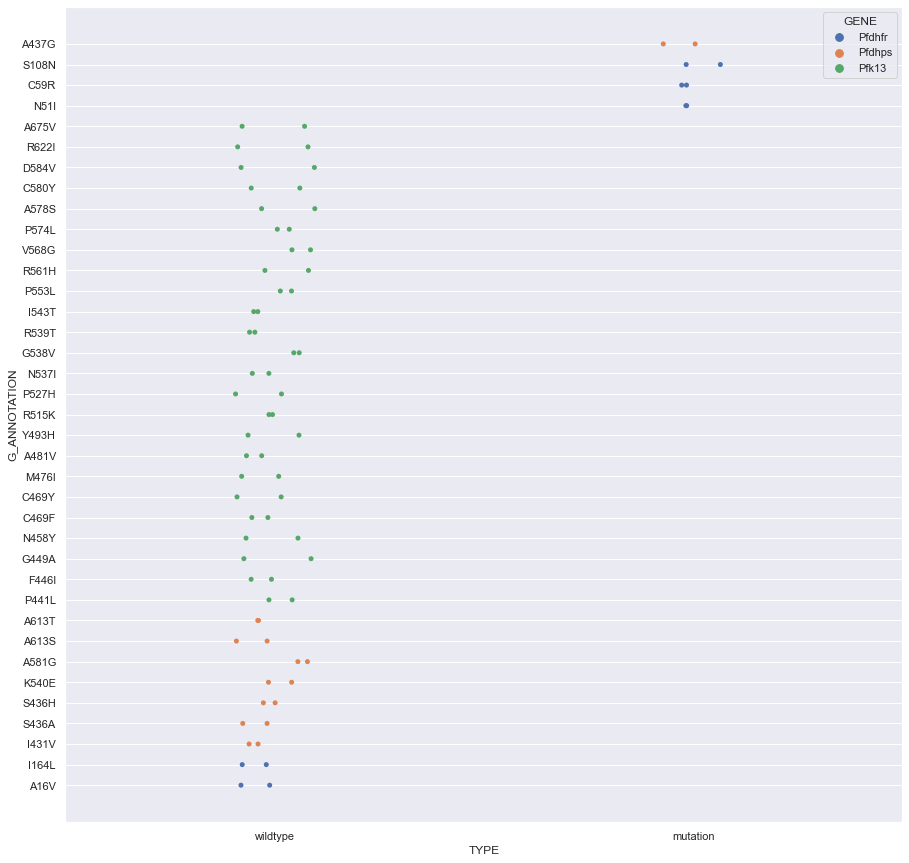

In [9]:
# Import dependencies

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Load data
df = pd.read_csv("ET_individual_EPI_VOI.csv")


# Check dataframe is correct 
df.head()

# Print number of rows and columns; confirm its longform data
print('The number of rows, columns:', df.shape) 
print('') # add space 

# Count number of unique samples in data 
uniq = df['ET_ID_IND']
print('There are', uniq.nunique(), 'samples in this dataset.')
print('') # add space 

# Check if there are any Null or NAs 

print('The number of null or NA values in data:')
print(df.isnull().sum())
print('') # add space 

# Sort data based on CODONS to ensure shown as ascending/descending in plot 

LS = df['G_ANNOTATION']  # Copy the full annotated SNPs into a new list called LS 

codon_num = [] # create an empty list 

# Loop through G_ANNOTATION list (LS) and strip first and last character 
for x in LS: 
    codon_num.append(int(x[1:-1]))  # IMPORTANTLY change from string to integer to allow num sorting 
    ## TODO: make this more pythonic and use rstrip() and lstrip().left()

# Add the new Codon column to the current dataframe 
df['Codon'] = codon_num

# Set seaborn plot style and size (NOTE: some plots will not be affected; see seaborn docs) 

#sns.set_style("whitegrid")

# Set plot/figure size 
sns.set(rc = {'figure.figsize':(15,15)})

print('Plotting all SNPs categorized as wildtype or mutant using seaborn:')

# Plot as seaborn strippplot sorting by Codon # and then Gene in ascending order 

g= sns.stripplot(data=df.sort_values(by=['GENE','Codon'], ascending=True),
               x="TYPE", y="G_ANNOTATION",
                 hue="GENE")  




### The Below two section of code plots the bar graph for Paired and Pooled together using the data from *_weighted_bysite_EPI.csv file. 

### Bar graph shows the wild type, major and minor allele frequencies of all the reportable SNPs described in VariantsOfInterest.csv file. Allele frequencies are indicated on the x axis, and the variants of interest and total number of samples are listed along the y-axis. The color coding indicates the type of mutation found in the samples; blue is for wild type, green for minor allele mutation and red for major allele mutation

In [10]:
df = pd.read_csv("ET_weighted_bysite_EPI.csv")

df['Type'] = ["Wildtype: AF=0%" if float(x.strip("%"))==0 else 'Minor: AF < 50%' if 0<float(x.strip("%"))<0.5 else 'Major: AF >= 50%' for x in df['VAF']]
#print(df)
df_viz = pd.DataFrame()
df_type = pd.DataFrame()

df_type["GENE"]=df.groupby(["GENE","G_ANNOTATION","Type"]).sum().reset_index()["GENE"]
df_type["G_ANNOTATION"]=df.groupby(["GENE","G_ANNOTATION","Type"]).sum().reset_index()["G_ANNOTATION"]
df_type["Type"]=df.groupby(["GENE","G_ANNOTATION","Type"]).sum().reset_index()["Type"]

df_type["Mutation"]=df.groupby(["GENE","G_ANNOTATION","Type"]).sum().reset_index()["Mutation"]
df_type["WildType"]=df.groupby(["GENE","G_ANNOTATION","Type"]).sum().reset_index()["WildType"]


df_type["Major: AF >= 50%"]=np.where(df_type["Type"]=="Major: AF >= 50%", df_type["Mutation"], 0)
df_type["Minor: AF < 50%"]=np.where(df_type["Type"]=="Minor: AF < 50%", df_type["Mutation"], 0)
df_type["Wildtype: AF=0%"]=df_type["WildType"]


df_type=df_type.drop(['Type'], axis=1)


df_final=df_type.groupby(["GENE","G_ANNOTATION"]).sum().reset_index()

df_final["GENE_G_anno"]=df_final["GENE"]+":"+df_final["G_ANNOTATION"]

df_final=df_final.drop(['GENE','G_ANNOTATION'], axis=1)
df_final=df_final.drop(['Mutation','WildType'], axis=1)

df_final["Total"]=df_final["Wildtype: AF=0%"]+df_final["Major: AF >= 50%"]+df_final["Minor: AF < 50%"]  # 


cols = list(df_final.columns)
a, b = cols.index('GENE_G_anno'), cols.index('Major: AF >= 50%')
cols[b], cols[a] = cols[a], cols[b]
df_final = df_final[cols]


df_final["Major: AF >= 50%"]=df_final["Major: AF >= 50%"]/df_final["Total"]
df_final["Minor: AF < 50%"]=df_final["Minor: AF < 50%"]/df_final["Total"]
df_final["Wildtype: AF=0%"]=df_final["Wildtype: AF=0%"]/df_final["Total"]

df_final.to_csv("Tab_Table_SNP_Total1_DF.csv", index=False)






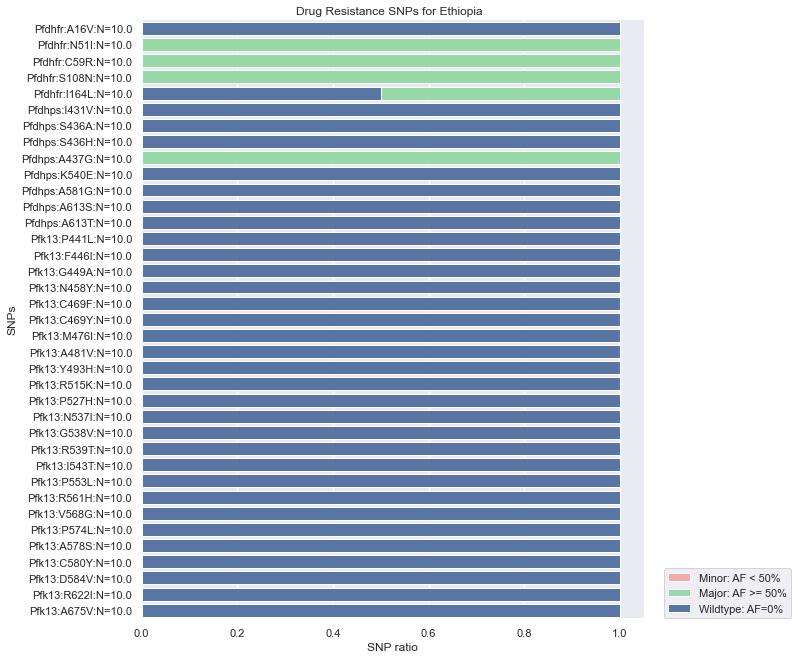

In [11]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
##Used the previously created table
df_table_SNP=pd.read_csv("Tab_Table_SNP_Total1_DF.csv")

df_table_SNP=df_table_SNP.sort_values(by=['GENE_G_anno'])

df_table_SNP["index"]=df_table_SNP.GENE_G_anno.str.split(":").str[1].str[1:-1]
df_table_SNP["index"]=df_table_SNP["index"].astype(int)
df_table_SNP["index2"]=df_table_SNP.GENE_G_anno.str.split(":").str[0]

df_table_SNP=df_table_SNP.sort_values(["index"])
#df.groupby('A', sort=False)
df_table_SNP=df_table_SNP.groupby(['index2'], sort=False)
df_table_SNP=pd.concat(map(lambda x: x[1], df_table_SNP))


df_table_SNP["Total"]=df_table_SNP["Total"].astype(str)
df_table_SNP["NewCol"]=df_table_SNP["GENE_G_anno"]+":"+"N="+df_table_SNP["Total"] ##Create the label for y-axis 
###The visualization works by adding different number of bars 
###There are three bars (total1 which has all major, minor, wildtypes, total2, just wildtype and major, and just wildtype
###The purpose is to create a stacked bar plots
df_table_SNP["total"]=df_table_SNP["Minor: AF < 50%"]+df_table_SNP["Major: AF >= 50%"]+df_table_SNP["Wildtype: AF=0%"] ##Create total for adding up all the bars by adding all the values for major minor and wildtype 
df_table_SNP["total2"]=df_table_SNP["Major: AF >= 50%"]+df_table_SNP["Wildtype: AF=0%"]
f, ax = plt.subplots(figsize = (9,11))
sns.set_color_codes('pastel')
##Once dataframes are created just plot the dataframe to the graph
ax = sns.barplot(x="total", y="NewCol", label = "Minor: AF < 50%", data=df_table_SNP, color = 'r', edgecolor = 'w')
ax = sns.barplot(x="total2", y="NewCol", label= "Major: AF >= 50%", data=df_table_SNP, color = 'g', edgecolor = 'w')
sns.set_color_codes('deep')
ax = sns.barplot(x="Wildtype: AF=0%", y="NewCol", label= "Wildtype: AF=0%", data=df_table_SNP, color = 'b', edgecolor = 'w')
ax.legend(ncol = 2, loc = 'lower right')
sns.despine(left = True, bottom = True)
ax.set(ylabel="Gene+SNP+#_of_Samples")
ax.set(xlabel="Types of mutations ratio")
plt.legend(loc=(1.04,0))
ax.set(title="Drug Resistance SNPs for Ethiopia  ", ylabel="SNPs", xlabel="SNP ratio")

plt.savefig('ET_Bar_plot_Combined3', bbox_inches='tight')
plt.show()
